# Slow traffic forecast

This model uses the database [Urban traffic density in cities](https://www.kaggle.com/datasets/tanishqdublish/urban-traffic-density-in-cities?resource=download) to predict the average traffic speed in the city.

This notebook explores RandomForestRegressor, a regression algorithm that uses a collection of decision trees. As we will see later, the choice of this algorithm was motivated by the nature of the data and the low relationship between the features analyzed.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../datasets/futuristic_city_traffic/futuristic_city_traffic.csv')

In [2]:
df.head()

,City,Vehicle Type,Weather,Economic Condition,Day Of Week,Hour Of Day,Speed,Is Peak Hour,Random Event Occurred,Energy Consumption,Traffic Density
0,SolarisVille,Drone,Snowy,Stable,Sunday,20,29.4268,0,0,14.7134,0.5241
1,AquaCity,Flying Car,Solar Flare,Recession,Wednesday,2,118.8000,0,0,143.5682,0.3208
2,Neuroburg,Autonomous Vehicle,Solar Flare,Recession,Wednesday,16,100.3904,0,0,91.2640,0.0415
3,Ecoopolis,Drone,Clear,Booming,Thursday,8,76.8000,1,0,46.0753,0.1811
4,AquaCity,Autonomous Vehicle,Solar Flare,Stable,Saturday,16,45.2176,0,0,40.1934,0.4544


In [3]:
df['City'].unique()

array(['SolarisVille', 'AquaCity', 'Neuroburg', 'Ecoopolis', 'TechHaven',
       'MetropolisX'], dtype=object)

In [4]:
df['Vehicle Type'].unique()

array(['Drone', 'Flying Car', 'Autonomous Vehicle', 'Car'], dtype=object)

Ranking of the cities with most cars.

In [5]:
df[df['Vehicle Type'] == 'Car']['City'].value_counts().sort_values(ascending=False)

AquaCity        25439
SolarisVille    20183
Ecoopolis       15275
MetropolisX      9959
TechHaven        4982
Neuroburg        2460
Name: City, dtype: int64

In [6]:
df_car = df[(df['Vehicle Type'] == 'Car') & (df['City'] == 'AquaCity')]
df_car

,City,Vehicle Type,Weather,Economic Condition,Day Of Week,Hour Of Day,Speed,Is Peak Hour,Random Event Occurred,Energy Consumption,Traffic Density
178,AquaCity,Car,Solar Flare,Recession,Thursday,23,65.3388,0,0,65.3388,0.2861
222,AquaCity,Car,Electromagnetic Storm,Stable,Sunday,13,86.4000,1,0,102.1339,1.0539
354,AquaCity,Car,Electromagnetic Storm,Booming,Saturday,12,26.7635,1,0,26.7635,0.7987
378,AquaCity,Car,Electromagnetic Storm,Booming,Sunday,16,62.0059,0,0,62.0059,0.9777
385,AquaCity,Car,Rainy,Booming,Saturday,14,23.1494,1,1,23.1494,0.5094
...,...,...,...,...,...,...,...,...,...,...,...
1219363,AquaCity,Car,Snowy,Booming,Wednesday,0,60.2543,0,0,60.2543,0.4992
1219392,AquaCity,Car,Snowy,Booming,Thursday,23,69.2789,0,0,69.2789,0.6848
1219399,AquaCity,Car,Clear,Booming,Sunday,8,42.2272,0,0,42.2272,1.4642
1219403,AquaCity,Car,Electromagnetic Storm,Stable,Wednesday,16,21.2711,0,0,21.2711,0.7462


In [7]:
df_car.dtypes

City                      object
Vehicle Type              object
Weather                   object
Economic Condition        object
Day Of Week               object
Hour Of Day                int64
Speed                    float64
Is Peak Hour               int64
Random Event Occurred      int64
Energy Consumption       float64
Traffic Density          float64
dtype: object

In [8]:
# Mapping the days of week to numbers
day_of_week_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

df_car_copy = df_car.copy()
df_car_copy.loc[:, 'Day Of Week'] = df_car_copy['Day Of Week'].map(day_of_week_mapping)
df_car = df_car_copy.copy()

In [9]:
df_car['Weather'].unique()

array(['Solar Flare', 'Electromagnetic Storm', 'Rainy', 'Snowy', 'Clear'],
      dtype=object)

In [10]:
# Mapping the weathers to numbers
weather_mapping = {
    'Solar Flare': 1,
    'Electromagnetic Storm': 2,
    'Rainy': 3,
    'Snowy': 4,
    'Clear': 5
}

df_car.loc[:, 'Weather'] = df_car['Weather'].map(weather_mapping)

In [11]:
# Filtering by columns related to usage scenario.
df_car =  df_car[["Weather", "Day Of Week", "Hour Of Day", "Speed", "Is Peak Hour", "Random Event Occurred", "Traffic Density"]]
df_car.reset_index(drop=True)

,Weather,Day Of Week,Hour Of Day,Speed,Is Peak Hour,Random Event Occurred,Traffic Density
0,1,4,23,65.3388,0,0,0.2861
1,2,7,13,86.4000,1,0,1.0539
2,2,6,12,26.7635,1,0,0.7987
3,2,7,16,62.0059,0,0,0.9777
4,3,6,14,23.1494,1,1,0.5094
...,...,...,...,...,...,...,...
25434,4,3,0,60.2543,0,0,0.4992
25435,4,4,23,69.2789,0,0,0.6848
25436,5,7,8,42.2272,0,0,1.4642
25437,2,3,16,21.2711,0,0,0.7462


In [12]:
df_car.dtypes

Weather                    int64
Day Of Week                int64
Hour Of Day                int64
Speed                    float64
Is Peak Hour               int64
Random Event Occurred      int64
Traffic Density          float64
dtype: object

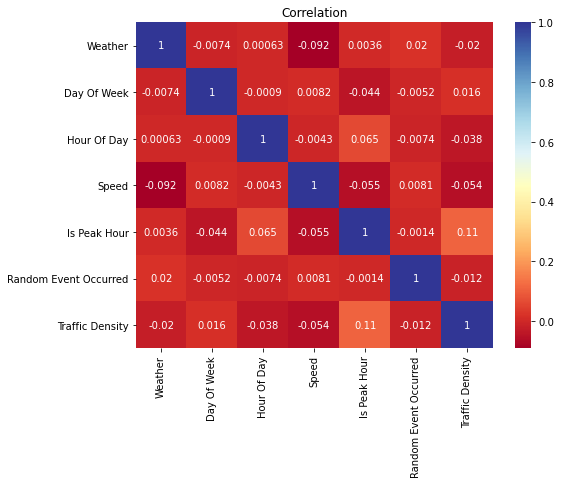

In [13]:
# Verify correlation
correlation_matrix = df_car.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu')
plt.title('Correlation')
plt.show()

Conclusion: We can see that there is a very weak relationship between the features.

## So, let's implement a regression model based on decision trees. We'll use the RandomForestRegressor.

In [14]:
# Generating a sample with same quandity of Random Event Occurred.

new_df_1 = df_car[df_car['Random Event Occurred'] == 1]
new_df_0 = df_car[df_car['Random Event Occurred'] == 0].sample(n=1348, random_state=42)

df_car_sample = pd.concat([new_df_1, new_df_0], axis=0)
df_car_sample = df_car_sample.reset_index(drop=True)

df_car_sample.shape

(2696, 7)

Creating a new column with Speed mean by Day Of Week and Hour Of Day

In [15]:
df_gb = df_car_sample.groupby(['Day Of Week', 'Hour Of Day'])['Speed'].median().reset_index()

df_gb = df_gb.rename(columns={'Speed': 'SpeedMean'})

df_car_sample = pd.merge(df_car_sample, df_gb, on=['Day Of Week', 'Hour Of Day'], how='left')

#df_car_sample

Creating the regression model.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df_car_sample[['Weather', 'Day Of Week', 'Hour Of Day', 'Is Peak Hour', 'Random Event Occurred', 'Traffic Density']]
y = df_car_sample['SpeedMean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 3.020996399134751
R2 Score: 0.9622548736603349


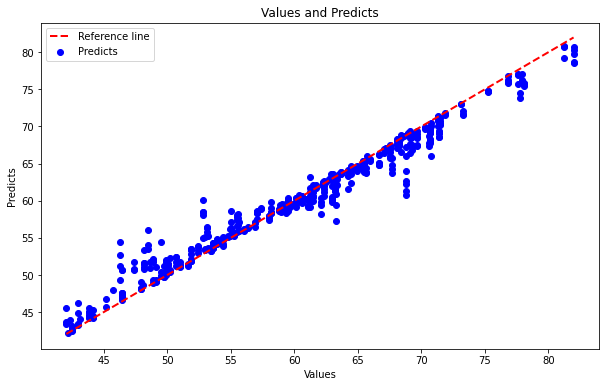

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicts')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Reference line')
plt.xlabel('Values')
plt.ylabel('Predicts')
plt.title('Values and Predicts')
plt.legend()
plt.show()

Exporting the model

In [18]:
import joblib
joblib.dump(model, 'slow-traffic-forecast-model.joblib')

['slow-traffic-forecast-model.joblib']

In [19]:
print(joblib.__version__)

1.2.0


In [20]:
import sklearn
print(sklearn.__version__)

1.3.2
